# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.data.build_graph import build_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=False)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 110 ms, sys: 115 ms, total: 225 ms
Wall time: 224 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 1000

# Investigate raw data

In [4]:
%%time

show=False
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    event = raw.loc[raw.index==evID]
    plot_event(event).plot_eventdisplay()
    
    data_eval = evaluate_data(raw)
    data_eval.plot_pzcut(2)
    data_eval.curler_dist()

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.68 µs


# Graph building for training

In [5]:
%%time
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
graphs = data.create_graph_list()

#show preprocessed data
data.events.sort_index()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:03<00:00, 255.17it/s]

CPU times: user 4.01 s, sys: 39.6 ms, total: 4.05 s
Wall time: 4.04 s


,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,72394,32.572498,341.390015,0.445295,7.657413,2,0,2,15,114,7,342.940388,0.095123
0,176200,-19.442499,639.869690,0.217349,2.603750,6,0,5,42,9,22,640.165003,-0.030376
0,207025,15.907500,423.839691,0.089051,5.259365,3,0,4,24,45,12,424.138105,0.037514
0,101566,16.412500,466.964996,0.054954,5.260012,4,0,4,31,52,15,467.253334,0.035133
0,180192,28.532499,326.894989,0.075142,3.068103,2,0,1,9,157,5,328.137833,0.087063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,15398,-28.532499,342.264679,0.167747,9.108500,2,0,3,16,72,8,343.451909,-0.083172
1000,79387,-57.317501,621.489990,0.169984,9.069591,5,0,3,39,79,19,624.127474,-0.091966
1000,65797,-66.407501,621.489990,0.424449,0.585620,5,0,4,39,39,19,625.027811,-0.106448


In [6]:
%%time 

targets = []
dir = 'data/graphs'

for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for graph in graphs:
    evID = graph.pid.index.unique()[0]
    x, edge_attr, edge_index, y, pid = graph
    targets.append(y)
    arr = np.asanyarray([x, edge_attr, edge_index, y, pid], dtype=object)
    np.save(f'{dir}/graph_{evID}.npy', arr)
print(f'graphs saved to {dir}')

targets = np.concatenate(targets)
print(f'signal fraction true/all edges: {np.sum(targets)/len(targets)}')


graphs saved to data/graphs
signal fraction true/all edges: 0.49225769451347734
CPU times: user 179 ms, sys: 27.6 ms, total: 207 ms
Wall time: 207 ms


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [7]:
%%time
evaluate = False

if evaluate:
    slope = np.linspace(0.1,4,20)
    print(slope)
    testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

    purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False)
        purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = np.mean(purity)
        efficiencies[i] = np.mean(efficiency)


    plot_information().plot_purity_efficiency(slope, 3, purities, efficiencies, 'slope cut', 'graph building', 'img/graphbuilding_purity_efficiency.pdf')

    plot_information(graphs=graphs).plot_graph_information()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.2 µs


# Plot Graphs

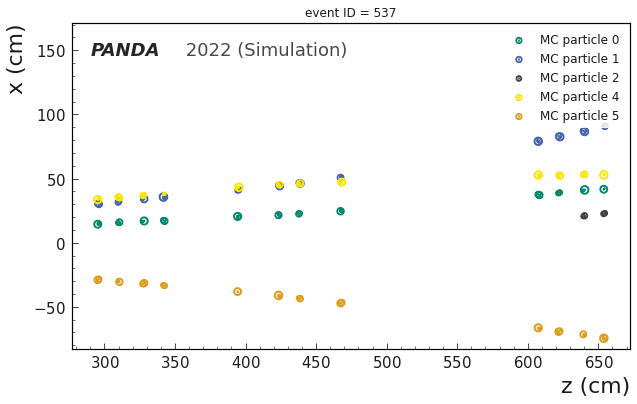

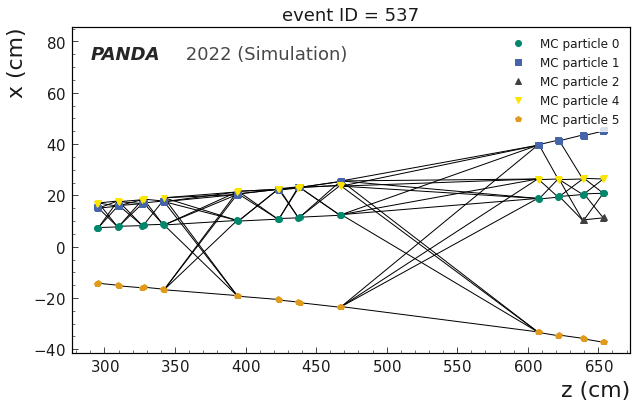

CPU times: user 1.43 s, sys: 246 ms, total: 1.67 s
Wall time: 1.38 s


In [8]:
%%time
evID = np.random.randint(nevents)

hits = data.events.loc[evID]
graph = graphs[evID]

plot_event(hits).plot_eventdisplay()
plot_event(graph=graph).plot_graphdisplay()



# Prepare Training

In [9]:
torch.manual_seed(42)
device = torch.device('cpu')
hidden_size = 30
lr = 0.01
gamma = 0.7
epochs = 2
patience = 4
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}

In [10]:
parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [11]:
model = InteractionNetwork(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
patience = 5
name = 'IN_trained_10Kevents_30neurons'

model.count_parameters()

InteractionNetwork(node_dim: 3, edge_dim: 4, hidden_size: 30)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |    300     |
|  R1.layers.0.bias  |     30     |
| R1.layers.2.weight |    900     |
|  R1.layers.2.bias  |     30     |
| R1.layers.4.weight |    120     |
|  R1.layers.4.bias  |     4      |
| O.layers.0.weight  |    210     |
|  O.layers.0.bias   |     30     |
| O.layers.2.weight  |    900     |
|  O.layers.2.bias   |     30     |
| O.layers.4.weight  |     90     |
|  O.layers.4.bias   |     3      |
| R2.layers.0.weight |    300     |
|  R2.layers.0.bias  |     30     |
| R2.layers.2.weight |    900     |
|  R2.layers.2.bias  |     30     |
| R2.layers.4.weight |     30     |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 3938


# Training

In [12]:
results = train_model(train_loader, val_loader, test_loader, model, optimizer, scheduler, epochs=epochs, patience=patience, name=name)

  0%|                                                                                                                          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 5.08s
Mean Train Batch Loss: 0.2192
TPR = 0.9553571428571429, TNR = 1.0
diff= 0.0008, nbest_disc= 0.5900
mean best disc 0.475


 20%|██████████████████████▊                                                                                           | 1/5 [00:07<00:28,  7.05s/it]


Test set: Average loss: 0.0021
, Accuracy: 0.9328

Validation loss decreased (inf --> 0.176095).  Saving model ...
Train Epoch: 2, epoch time: 5.63s
Mean Train Batch Loss: 0.1664
TPR = 0.967741935483871, TNR = 1.0
diff= 0.0000, nbest_disc= 0.2000
mean best disc 0.535


 40%|█████████████████████████████████████████████▌                                                                    | 2/5 [00:14<00:21,  7.27s/it]


Test set: Average loss: 0.0036
, Accuracy: 0.9336

Validation loss decreased (0.176095 --> 0.169154).  Saving model ...
Train Epoch: 3, epoch time: 5.21s
Mean Train Batch Loss: 0.1532
TPR = 0.8131868131868132, TNR = 0.9565217391304348
diff= 0.0099, nbest_disc= 0.4800
mean best disc 0.447


 60%|████████████████████████████████████████████████████████████████████▍                                             | 3/5 [00:21<00:14,  7.20s/it]


Test set: Average loss: 0.0006
, Accuracy: 0.9309

EarlyStopping counter: 1 out of 5
Train Epoch: 4, epoch time: 5.44s
Mean Train Batch Loss: 0.1500
TPR = 0.9146341463414634, TNR = 1.0
diff= 0.0050, nbest_disc= 0.2000
mean best disc 0.434


 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 4/5 [00:28<00:07,  7.19s/it]


Test set: Average loss: 0.0014
, Accuracy: 0.9377

Validation loss decreased (0.169154 --> 0.160937).  Saving model ...
Train Epoch: 5, epoch time: 5.69s
Mean Train Batch Loss: 0.1490
TPR = 0.9487179487179487, TNR = 1.0
diff= 0.0001, nbest_disc= 0.4600
mean best disc 0.526


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:36<00:00,  7.28s/it]


Test set: Average loss: 0.0010
, Accuracy: 0.9381

EarlyStopping counter: 1 out of 5


In [13]:
model, losses, accs, disc, test_losses, test_accs = results.trained

# Evaluate Training

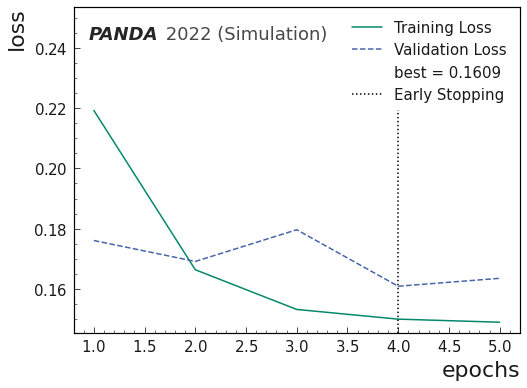

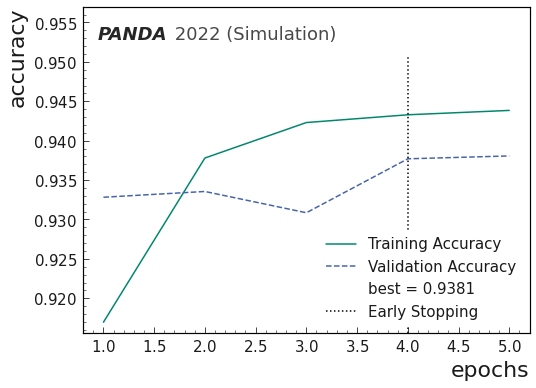

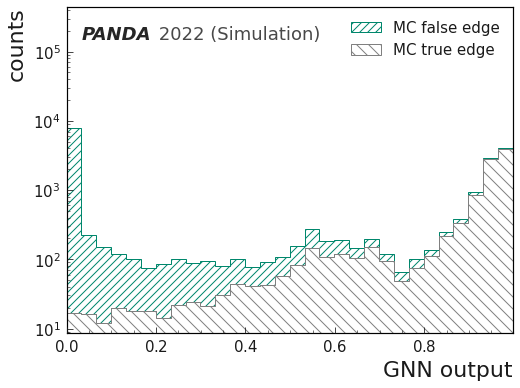

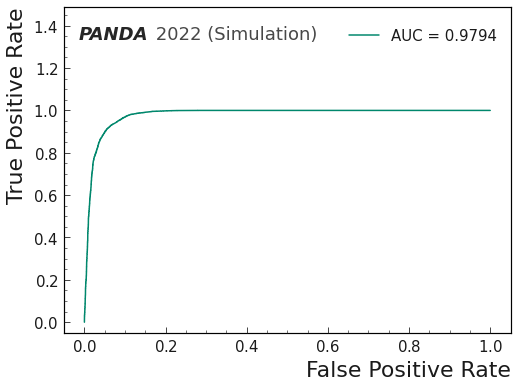

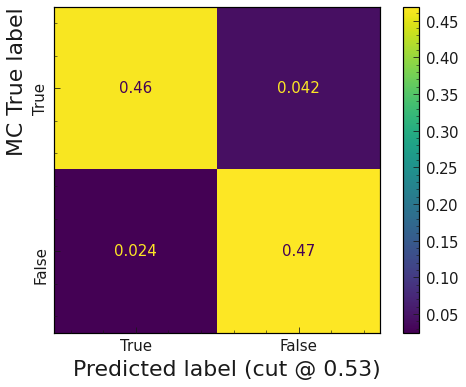

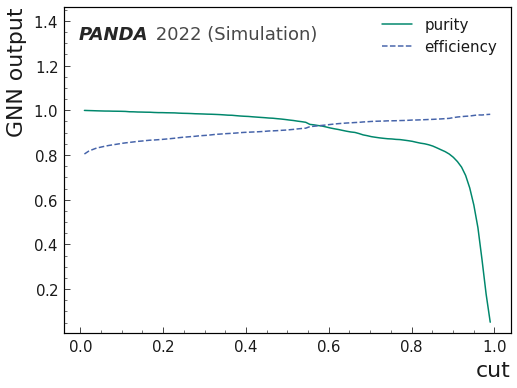

In [14]:
evaluation = evaluate_model('cpu', model, test_loader, losses, test_losses, accs, test_accs, disc, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

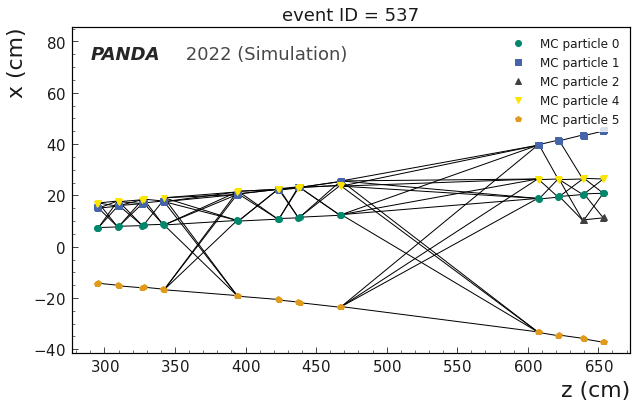

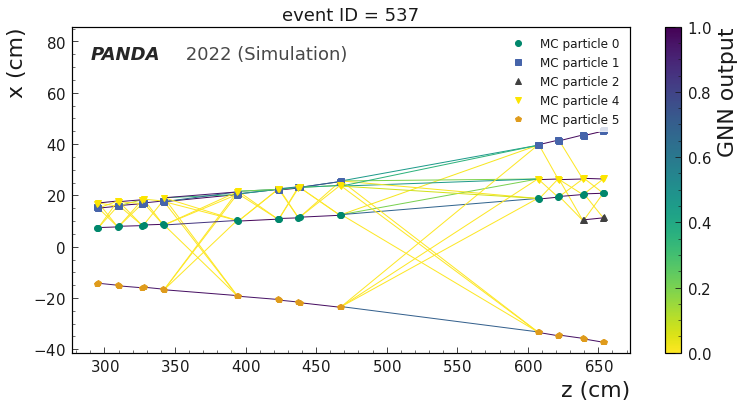

In [15]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)